<a href="https://colab.research.google.com/github/marcelovolta/cawork/blob/master/Copia_de_Colab_Base_para_el_Trabajo_Pr%C3%A1ctico_(versi%C3%B3n__005b).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Base para el Trabajo Práctico (versión 5b)
Programa de creación de entregas. Versión 1

In [36]:
# Celda 01: Importar las bibliotecas necesarias
import pandas as pd
import numpy as np

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [37]:
# Celda 02: Montar Google drive. Una vez montado puede explorarse desde la barra izquierda
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0. Lectura de datos

In [38]:
# Celda 03: Especificar directorio base donde están los archivos de datos
DIR = "/content/drive/MyDrive/Colab Notebooks/DM/archivos de datos"


In [39]:
# Celda 04: Cargar los datos. Ojo: Lleva unos segundos largos. También cargo los valores a predecir,
# para darles el mismo tratamiento que a los datos de entrenamiento

df_ent = pd.read_csv(f"{DIR}/entrenamiento/entrenamiento.csv", index_col="id")
# print("Datos de Entrenamiento")
# print(df_ent.head())


df_ap = pd.read_csv(f"{DIR}/a_predecir.csv", index_col="id")
# print("Datos a predecir")
# print(df_ap.head())

In [40]:
# cantidad de filas y columnas de datos de entrenamiento: 985.180 datos con 24 features
# cantidad de filas y columnas de datos a predecir: 7.012 datos con 24 features
print(df_ent.shape)
print(df_ap.shape)

(985180, 24)
(7012, 24)


## 1. Entender los datos (AID)
Estos histogramas son simpáticos pero de valor limitado

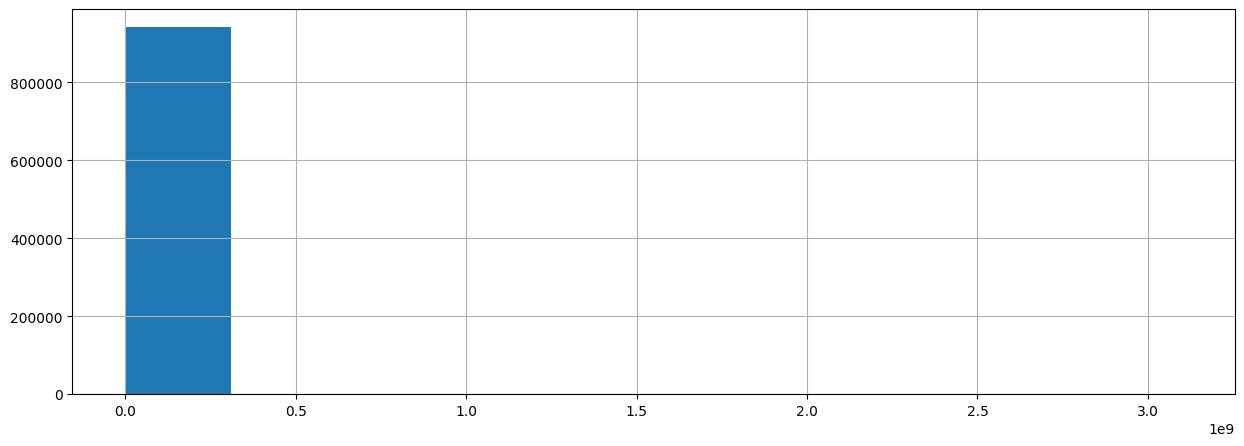

In [ ]:
df_ent["price"].hist(figsize=(15,5));

## 2. Limpiar y transformar los datos (MD)

## 2.a Datos de Localización
Estos datos son muy importantes porque el valor de una propiedad responde fuertemente a la ubicación.
Revisando los datos de entrenamiento veo que hay datos de Argentina, Uruguay y Brasil. Dentro de Argentina, hay varias provincias. En los datos de predicción en cambio, sólo hay datos de Capital Federal. A fin de limpiar los datos y de hacer más manejable el dataset vamos a quitar de los datos de entrenamiento todo lo que no sea Capital Federal. Esto es importante para convertir el dato de ubicación a numérico de modo que el modelo los pueda usar para entrenar.


In [41]:
# ==============================
# Datos de Ubicación
# ==============================

# Selección de datos de Capital
df_ent = df_ent.loc[(df_ent["l2"] == "Capital Federal")]
# No hace falta filtrar los datos de predicción

# Revisemos si el dataset de predicción tiene barrios que no están en entrenamiento
# Valores únicos en cada dataframe
valores_ent = set(df_ent['l3'].unique())
valores_ap = set(df_ap['l3'].unique())

# Diferencias: Usando el código de más abajo obtengo un conjunto vacío, es decir que estamos bien
solo_en_ap = valores_ap - valores_ent
print("Valores que están SOLO en df_ap:", solo_en_ap)


# Ahora convertimos el valor de l3 en numérico para poder usarlo como feature en el modelo
# Para eso usamos el label encoder de SKLearn. Dado que es posible que tenga que hacer esto con otros features, armemos una función para no duplicar código

def label_encoder(columna, nueva_columna):
    le = sk.preprocessing.LabelEncoder()
    le.fit(df_ent[columna].str.strip().str.lower()) # elijo df_ent porque tiene todos los barrios que aparecen en df_ap
    # Antes de transform quito espacios sobrantes y paso a lowercase para asegurarme que la codificación es consistente
    df_ent[nueva_columna] = le.transform(df_ent[columna].str.strip().str.lower())
    df_ap[nueva_columna] = le.transform(df_ap[columna].str.strip().str.lower())


    #df[columna] = le.fit_transform(df[columna])
    #return df

label_encoder('l3', 'l3_transform')


# En este punto, los valores de l1 y l2 son irrelevantes. Podría tirarlos pero eso sucede en el drop de valores no numéricos que se hace al final

Valores que están SOLO en df_ap: set()


In [42]:
# Veamos cuantos datos tenemos: 242.726
print(df_ent.shape)


(242726, 25)


In [43]:
# ==============================
# Datos de Currency
# ==============================

# Hay valores en AR$!! por ahora quito
# los valores sabiendo que estoy perdiendo 60.543 datos en AR$ y 8.291 que son nulos:
# ToDo: Para los que están en Pesos AR, calcular en valor en USD usando el precio del dolar al momento en que los avisos estaban activos
# ToDo: En los valores a predecir hay sólo 6 en AR$ - Pasarlos de Dolar a Peso para disminuir el error
df_ent = df_ent.loc[(df_ent["currency"] == "USD")]
print(df_ent.shape) # 173.892

(173892, 25)


In [44]:
# ==============================
# Datos de Tipo de Operacion
# ==============================

# Hay Operaciones que no son Ventas!!
# En general se acepta que el valor de un alquiler mensual es un 5.38% del valor de venta, pero por ahora quitamos operaciones que no son ventas
# ToDo: Considerar si vale la pena agregar operaciones que no son ventas, multiplicando el valor del alquiler por la inversa del 5.38%
df_ent = df_ent.loc[(df_ent["operation_type"] == "Venta")]
print(df_ent.shape) #162.048

(162048, 25)


In [45]:
# ==============================
# Datos de Tipo de Vivienda
# ==============================

# También requieren un label encoding. EL nombre del campo es property_type
# Revisemos si el dataset de predicción tiene tipos que no están en entrenamiento
# Valores únicos en cada dataframe
valores_ent = set(df_ent['property_type'].unique())
valores_ap = set(df_ap['property_type'].unique())

# Diferencias: Usando el código de más abajo obtengo un conjunto vacío, es decir que estamos bien
solo_en_ap = valores_ap - valores_ent
print("Valores que están SOLO en df_ap:", solo_en_ap)

# Ahora codifiquemos
label_encoder('property_type', 'prop_type_transform')


Valores que están SOLO en df_ap: set()


In [46]:
# ==============================
# Etiquetas!!!
# ==============================

# Hay unas cuantas etiquetas nulas en los datos de entrenamiento
# En primera aproximación, borramos toda la fila para evitar poner un cero allí
# TODO: mejorar el tratamiento de etiquetas faltantes

df_ent = df_ent.dropna(subset=["price"])
print("éste es el shape resultante, para ver con cuántas filas me quedé") # 162.048
print(df_ent.shape)

# Grabamos los dos datasets para poder partir desde acá
df_ent.to_csv(f"{DIR}/entrenamiento_limpio.csv")
df_ap.to_csv(f"{DIR}/a_predecir_limpio.csv")

éste es el shape resultante, para ver con cuántas filas me quedé
(162048, 26)


In [74]:
# =====================================
# PARTIR DESDE ACÁ
# =====================================
# Puedo usar el entrenamiento limpio para partir desde acá y no necesitar todos los pasos anteriores
df_ent = pd.read_csv(f"{DIR}/entrenamiento_limpio.csv", index_col="id")
df_ap = pd.read_csv(f"{DIR}/a_predecir_limpio.csv", index_col="id")

In [75]:
# La creación de modelos requiere que no haya valores perdidos
# por eso llenamos todo con 0 a lo bestia
# TODO: mejorar la imputación de valores perdidos
df_ent = df_ent.fillna(0)

## 3. Entrenamiento del modelos (AA)

In [76]:
# La creación de modelos requiere que todo el dataframe sea numérico
# Me quedo con las columnas numéricas solamente
# TODO: traducir las columnas con datos no numéricos a numéricos para que mejoren los modelos
df_ent = df_ent.select_dtypes('number')

X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

In [77]:
X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

# Definimos el valor de los hiperparámetros a usar por el modelo
# TODO: hacer pruebas cambiando los valores de los hiperparámetros para mejorar el score
n_estimators = 50
max_depth = 5

### NO CAMBIAR RandomForestRegressor por otro modelo
### NOTA: Si en la primera entrega usan otro modelo, su nota será 0
### Pueden cambiar los hiperparámetros que afectan al árbol: n_estimators, criterion, max_depth, min_samples_split, min_samples_leaf, min_weight_fraction_leaf, max_features, max_leaf_nodes, min_impurity_decrease
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)

# Entrenamos el modelo
_ = reg.fit(X_train, y_train)

# Cálculo del error en entrenamiento (train)
y_pred = reg.predict(X_train)
score_train = sk.metrics.root_mean_squared_error(y_train, y_pred)

# Cálculo del error en prueba (test)
y_pred = reg.predict(X_test)
score_test  = sk.metrics.root_mean_squared_error(y_test,  y_pred)

print(f"{n_estimators=} -- {max_depth=} --> {score_train=:.2f} - {score_test=:.2f}")

n_estimators=50 -- max_depth=5 --> score_train=369351.31 - score_test=396323.47


## 4. Solución para subir Kaggle

In [78]:

#df_ap = pd.read_csv(f"{DIR}/a_predecir.csv", index_col="id")
#df_ap.head()

In [79]:
df_ap.shape
df_ap.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,surface_covered,currency,price_period,title,description,property_type,operation_type,price,l3_transform,prop_type_transform
id,,,,,,,,,,,,,,,,,,,,,
1068,Propiedad,2020-06-21,2020-06-27,2020-06-21,NaN,NaN,Argentina,Capital Federal,Palermo,Palermo Viejo,...,160.0,USD,NaN,Casa de 4 ambientes en Venta en Palermo viejo,TRIPLEX EN MEDIO TERRENO DE 4 AMB MUY AMPLIOS...,Casa,Venta,NaN,27,0
1069,Propiedad,2020-06-21,2020-06-27,2020-06-21,-58.426576,-34.590987,Argentina,Capital Federal,Palermo,NaN,...,270.0,USD,NaN,Casa de 8 ambientes en Venta en Palermo,OPORTUNIDAD!! Edificio en Block desarrollado e...,Casa,Venta,NaN,27,0
1073,Propiedad,2020-06-21,2020-06-24,2020-06-21,-58.479808,-34.631266,Argentina,Capital Federal,Floresta,NaN,...,120.0,USD,NaN,Venta de casa en PH en Floresta,Casa con muy buena distribución y de amplios a...,Casa,Venta,NaN,19,0
1082,Propiedad,2020-06-21,2020-06-27,2020-06-21,-58.437889,-34.603291,Argentina,Capital Federal,Villa Crespo,NaN,...,185.0,USD,NaN,Casa de 5 ambientes en Venta en Villa crespo,SON 185 METROS CUBIERNTOS CON COCHERA MAS PATI...,Casa,Venta,NaN,45,0
1091,Propiedad,2020-06-21,2020-06-27,2020-06-21,-58.476461,-34.602494,Argentina,Capital Federal,Villa del Parque,NaN,...,106.0,USD,NaN,Venta de casa de tres ambientes en Villa del P...,"Hermosa casa ubicada en zona residencial, sobr...",Casa,Venta,NaN,46,0


In [80]:
X = df_ent[df_ent.columns.drop('price')]
y = df_ent['price']

# Entrenamos el modelo con todos los datos de entrenamiento.csv
reg.fit(X, y)

RandomForestRegressor(max_depth=5, n_estimators=50, n_jobs=-1, random_state=42)

In [81]:
# Hacemos en df_ap la misma limpieza que en df_ent
df_ap = df_ap.fillna(0)
# Preparo una máscara que voy a necesitar después
es_ars = df_ap["currency"] == "ARS"
print(es_ars.head)

df_ap = df_ap.select_dtypes('number')

X_ap = df_ap[X.columns]
# y_ap = df_ap['price'] # no es necesario!

# Predecimos los precios del dataset a predecir
y_pred_ap = reg.predict(X_ap)

# Paso adicional: Hay 6 valores en pesos, vamos a multiplicarlos por 117 que es el
# promedio de la cotización del dólar en el rango de fechas en que están esos valores
# a predecir

y_pred_ap[es_ars] *= 117


print(X_ap)
print(y_pred_ap)

<bound method NDFrame.head of id
1068      False
1069      False
1073      False
1082      False
1091      False
          ...  
960218    False
960220    False
960226    False
960227    False
960229    False
Name: currency, Length: 7012, dtype: bool>
              lat        lon   l5   l6  rooms  bedrooms  bathrooms  \
id                                                                   
1068     0.000000   0.000000  0.0  0.0    0.0       3.0        1.0   
1069   -58.426576 -34.590987  0.0  0.0    0.0       7.0        5.0   
1073   -58.479808 -34.631266  0.0  0.0    0.0       3.0        2.0   
1082   -58.437889 -34.603291  0.0  0.0    0.0       4.0        3.0   
1091   -58.476461 -34.602494  0.0  0.0    0.0       2.0        2.0   
...           ...        ...  ...  ...    ...       ...        ...   
960218 -58.420206 -34.602580  0.0  0.0    4.0       3.0        1.0   
960220 -58.411129 -34.578322  0.0  0.0    4.0       3.0        1.0   
960226 -58.462594 -34.572645  0.0  0.0    4.0   

In [82]:
# Lleno el precio de df_ap con las predicciones
df_ap["price"] = y_pred_ap

# Grabo el df_ap en un archivo csv para subir a Kaggle. Ojo, tarda unos segundos largos en grabarse.
df_ap["price"].to_csv(f"{DIR}/solucion.csv")